<a href="https://colab.research.google.com/github/JakobWyatt/autonomous-wheelchair-thesis/blob/main/colab/TrainSegModels_HybridNets.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [20]:
!pip install -q torch==1.12.0 torchvision timm webcolors albumentations efficientnet-pytorch pretrainedmodels
!git clone https://github.com/datvuthanh/HybridNets
!mkdir datasets
!unzip drive/MyDrive/Thesis/datasets/bdd100k/bdd100k_images_100k.zip -d datasets/
!unzip drive/MyDrive/Thesis/datasets/bdd100k/det_annotations.zip -d datasets/
!unzip drive/MyDrive/Thesis/datasets/bdd100k/da_seg_annotations.zip -d datasets/
!unzip drive/MyDrive/Thesis/datasets/bdd100k/ll_seg_annotations.zip -d datasets/

fatal: destination path 'HybridNets' already exists and is not an empty directory.
mkdir: cannot create directory ‘datasets’: File exists
Archive:  drive/MyDrive/Thesis/datasets/bdd100k/bdd100k_images_100k.zip
replace datasets/bdd100k/images/100k/train/9e663dc4-76234e28.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: Archive:  drive/MyDrive/Thesis/datasets/bdd100k/det_annotations.zip
replace datasets/data2/zwt/bdd/bdd100k/labels/100k/train/5b952ae7-1df75509.json? [y]es, [n]o, [A]ll, [N]one, [r]ename: Archive:  drive/MyDrive/Thesis/datasets/bdd100k/da_seg_annotations.zip
replace datasets/bdd_seg_gt/train/1f864b3f-a736fa8b.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: Archive:  drive/MyDrive/Thesis/datasets/bdd100k/ll_seg_annotations.zip
replace datasets/bdd_lane_gt/train/1f864b3f-a736fa8b.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [21]:
import torch
import sys
sys.path.insert(0, "./HybridNets")
from hybridnets.model import ModelWithLoss

model = torch.hub.load('datvuthanh/hybridnets', 'hybridnets', pretrained=True, device='cpu')
model.eval()
model = ModelWithLoss(model)

Using cache found in /root/.cache/torch/hub/datvuthanh_hybridnets_main


In [42]:
from hybridnets.dataset import BddDataset
from utils.utils import Params
from torchvision import transforms
params = Params('./HybridNets/projects/bdd100k.yml')
params.dataset['dataroot'] = "./datasets/bdd100k/images/100k"
train_dataset = BddDataset(
    params=params,
    is_train=True,
    inputsize=params.model['image_size'],
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(
            mean=params.mean, std=params.std
        )
    ])
)
test_dataset = BddDataset(
    params=params,
    is_train=False,
    inputsize=params.model['image_size'],
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(
            mean=params.mean, std=params.std
        )
    ])
)

building database...


  0%|          | 0/70000 [00:00<?, ?it/s]

database build finish
building database...


  0%|          | 0/10000 [00:00<?, ?it/s]

database build finish


In [44]:
from torch.utils.data import DataLoader
import torch.optim as optim
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=2, collate_fn=BddDataset.collate_fn)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=True, num_workers=2, collate_fn=BddDataset.collate_fn)
optimizer = torch.optim.AdamW(model.parameters())

In [37]:
import PIL
import numpy as np

# make segmentation pretty again
def colorfill_segmentation(seg):
    colors = np.array([[0, 0, 0], [0, 128, 0], [0, 0, 128]], dtype=np.uint8)
    seg_mask = seg.byte().cpu().numpy()
    seg_mask = PIL.Image.fromarray(seg_mask)
    seg_mask.putpalette(colors)
    seg_mask = seg_mask.convert("RGB")
    seg_mask = np.array(seg_mask, dtype=np.uint8)
    return seg_mask

tensor(1.5433)


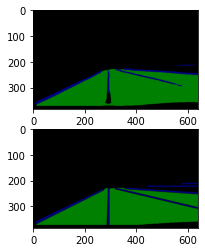

In [41]:
import matplotlib.pyplot as plt
plt.ion()
# Get an idea of our initial loss
with torch.no_grad():
    for data in train_loader:
        imgs = data['img']
        #plt.imshow(imgs[0].permute(1, 2, 0))
        annot = data['annot']
        seg_annot = data['segmentation']
        cls_loss, reg_loss, seg_loss, regression, classification, anchors, segmentation = model(imgs, annot, seg_annot, obj_list=params.obj_list)
        fig, ax = plt.subplots(2)
        ax[0].imshow(colorfill_segmentation(segmentation[0].argmax(0)))
        ax[1].imshow(colorfill_segmentation(seg_annot[0]))
        print(seg_loss)
        break

In [ ]:
# Measure IoU from our test set
